# Content
1. ['Optimizing Portfolio Sharp'](#1)
- Given a list of tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'BRK-A', 'V', 'JNJ', 'WMT']

- Highest sharpe ratio of 1.07 is attained with high weight in MSFT (40%).  The performance of MSFT dominates the portfolio. TSLA, JNJ and WMT have weights of 12%, the rest are less than 10%. 

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

import warnings
warnings.filterwarnings('ignore')

# 1. Optimizing Portfolio Sharpe
<a id='1'></a>

- Given a list of tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'BRK-A', 'V', 'JNJ', 'WMT']

- Highest sharpe ratio of 1.07 is attained with high weight in MSFT (40%).  The performance of MSFT dominates the portfolio. TSLA, JNJ and WMT have weights of 12%, the rest are less than 10%. 


In [143]:
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'BRK-A', 'V', 'JNJ', 'WMT']

for ticker in tickers:
    df = pdr.get_data_yahoo(ticker, start='2013-01-01', end='2023-11-18')
    df = df[['Adj Close']]
    df = df.rename(columns={'Adj Close': ticker})
    
    if ticker == tickers[0]:
        dfmerge = df
    else:
        dfmerge = dfmerge.join(df, how='outer')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [145]:
dfmerge.head()

,AAPL,MSFT,AMZN,GOOGL,META,TSLA,BRK-A,V,JNJ,WMT
Date,,,,,,,,,,
2013-01-02,16.769089,22.574520,12.8655,18.099348,28.000000,2.357333,139610.0,35.941456,52.788986,54.823959
2013-01-03,16.557428,22.272110,12.9240,18.109859,27.770000,2.318000,140549.0,35.969204,52.714455,54.475567
2013-01-04,16.096231,21.855272,12.9575,18.467718,28.760000,2.293333,140803.0,36.262966,53.318062,54.681427
2013-01-07,16.001549,21.814409,13.4230,18.387136,29.420000,2.289333,140190.0,36.522038,53.206280,54.158855
2013-01-08,16.044609,21.699976,13.3190,18.350851,29.059999,2.245333,141000.0,36.862072,53.213741,54.309292


In [146]:
dfret = dfmerge.pct_change().apply(lambda x: np.log(1+x)).dropna()

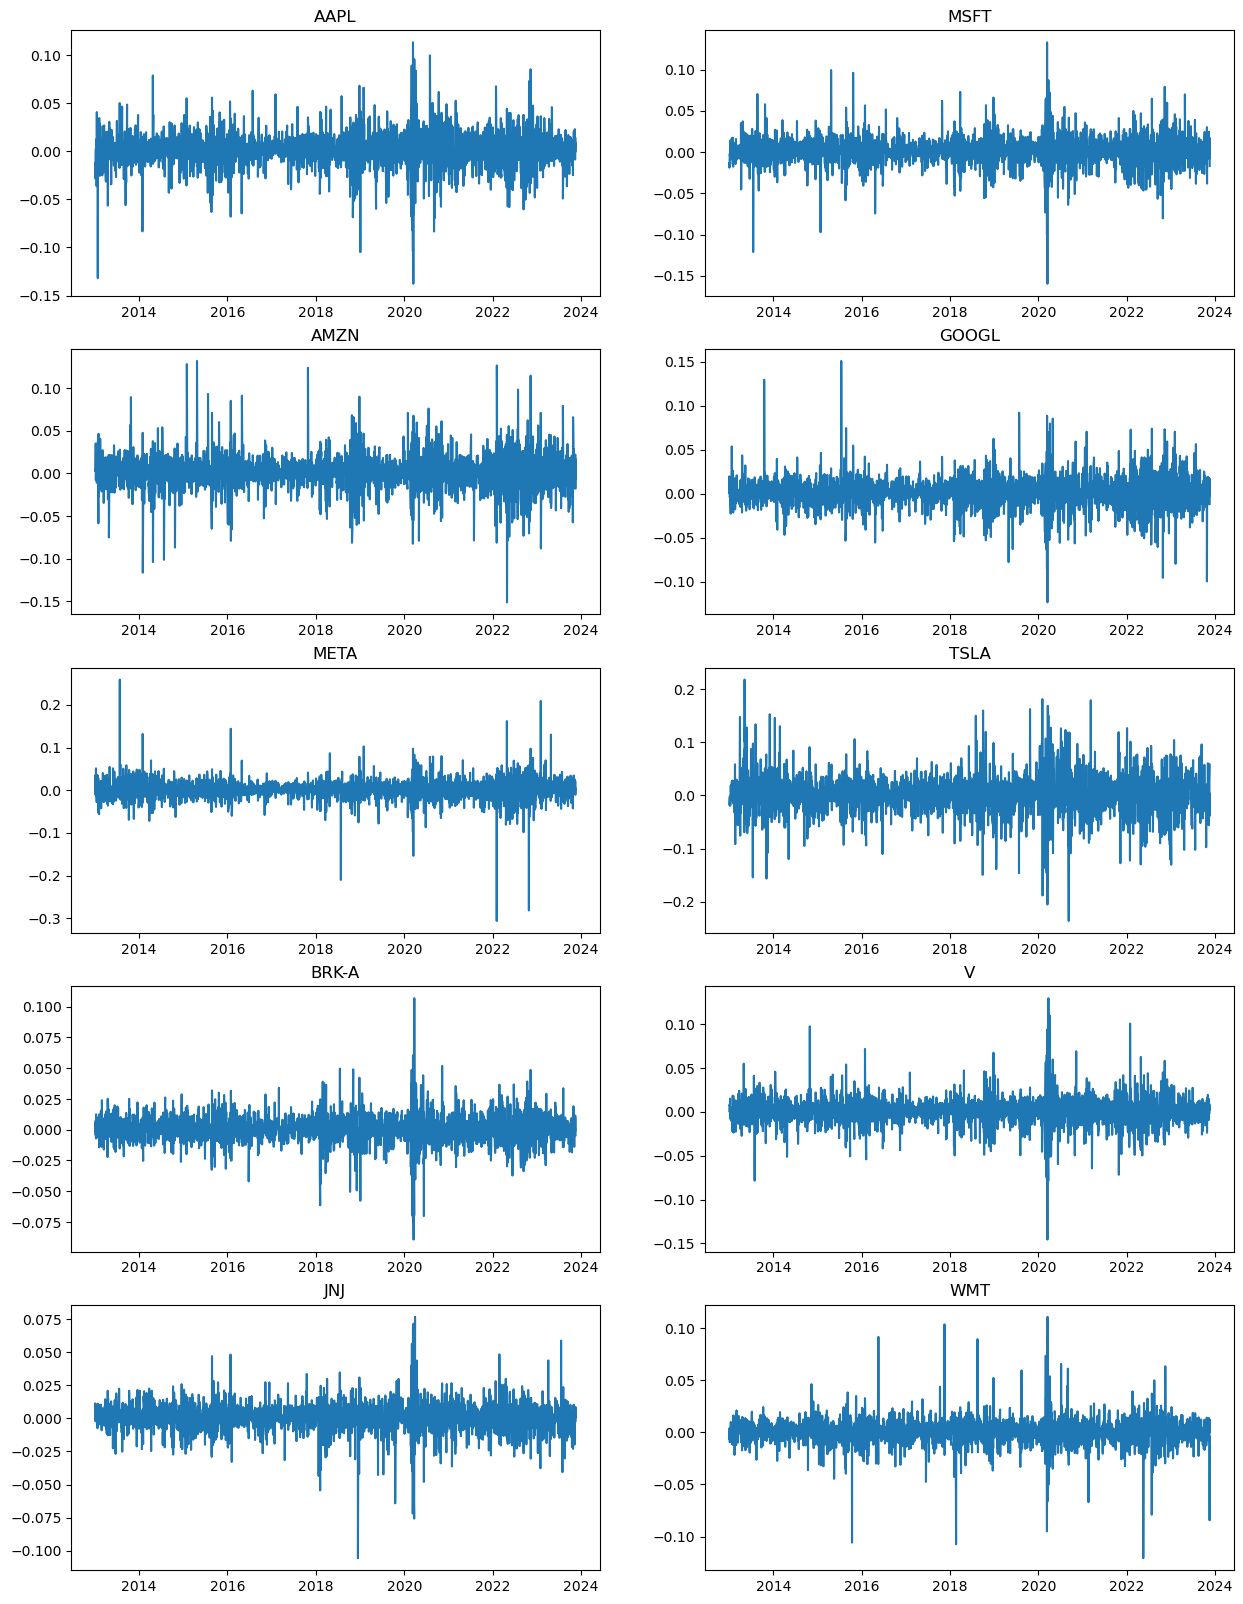

In [150]:
fig, ax1 = plt.subplots(ncols=2, nrows=5, figsize=(15, 20))  # Set the figure size here
ax = ax1.flatten()

for col, ax in zip(dfret.columns, ax):
    ax.plot(dfret[col])
    ax.set_title(col)

<Axes: >

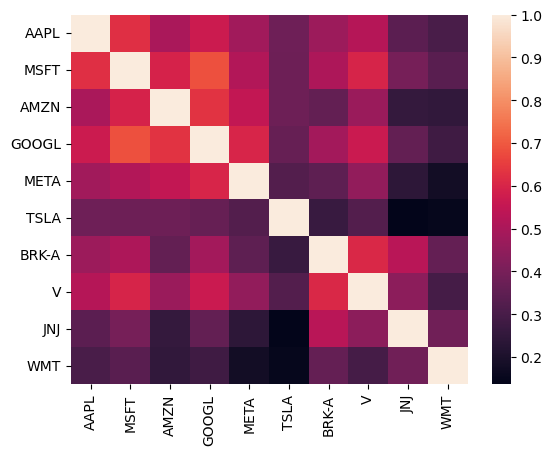

In [148]:
import seaborn as sns
sns.heatmap(dfret.corr())

In [151]:
dfcumuret = dfret.cumsum().apply(np.exp)
dfcumuret.head()

,AAPL,MSFT,AMZN,GOOGL,META,TSLA,BRK-A,V,JNJ,WMT
Date,,,,,,,,,,
2013-01-03,0.987378,0.986604,1.004547,1.000581,0.991786,0.983315,1.006726,1.000772,0.998588,0.993645
2013-01-04,0.959875,0.968139,1.007151,1.020353,1.027143,0.972851,1.008545,1.008945,1.010022,0.997400
2013-01-07,0.954229,0.966329,1.043333,1.015900,1.050714,0.971154,1.004154,1.016154,1.007905,0.987868
2013-01-08,0.956797,0.961260,1.035249,1.013896,1.037857,0.952489,1.009956,1.025614,1.008046,0.990612
2013-01-09,0.941843,0.966691,1.035133,1.020560,1.092500,0.951358,1.002793,1.041253,1.012563,0.990323


<Axes: xlabel='Date'>

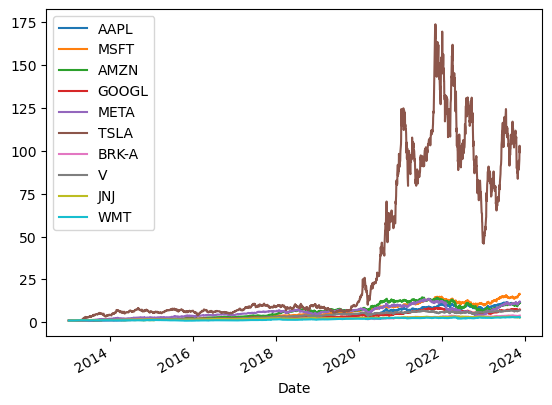

In [152]:
dfcumuret.plot()

<Axes: xlabel='Date'>

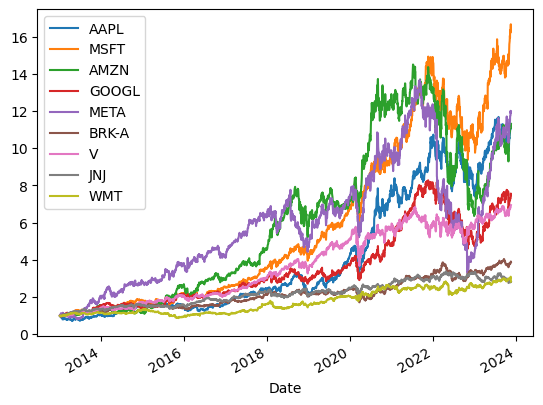

In [153]:
tickers_exTSLA = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'BRK-A', 'V', 'JNJ', 'WMT']

dfcumuret_exTSLA = dfcumuret[tickers_exTSLA]
dfcumuret_exTSLA.plot()

# Find stock weights (w) that minimize portfolio volatility

In [173]:
import scipy
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

bounds = Bounds(0,1) # all weights between 0 and 1
linear_constraint = LinearConstraint(np.ones(10), 1,1) # sum of weight >1 and <1, hence sum of weight = 1 (equality constraint)
covar=dfret.cov()
r=np.mean(dfret,axis=0)*252 # r = mean return of each stock

weights = np.ones(10)
x0 = [0.1]*10 # initial guess of respective weights

portfstrderr = lambda w: np.sqrt(np.dot(w, np.dot(w,covar))*252)

res1 = minimize(portfstrderr, x0, method='trust-constr', constraints=linear_constraint, bounds=bounds)

# methods?
- <u/>trust-constr</u>
    - equality and inequality constraints
    - (eg) optimize portfolio weights, given that sum of weights equal 1
- <u/>BFGS</u>
    - unconstrained 
    - (eg) minimum of a quadratic function
- <u/>L-BFGS-B</u>
    - bound constraints

In [200]:
def ret(r,w):
    return r.dot(w)

def vol(w,covar):
    return np.sqrt(np.dot(w, np.dot(w,covar))*252)

def sharpe(ret, vol):
    return ret/vol

w_min = res1.x
ret1 = ret(r,w_min)
vol1 = vol(w_min,covar)
sharpe1 = sharpe(ret1, vol1)
print('return = ', round(ret1,2))
print('vol = ', round(vol1,2))
print('sharpe ratio = ', round(sharpe1,2))

return =  0.11
vol =  0.15
sharpe ratio =  0.76


# Maximize sharpe ratio

In [178]:
invSharpe = lambda w: np.sqrt(np.dot(w, np.dot(w,covar))*252)   /    r.dot(w)
res2 = minimize(invSharpe, x0, method='trust-constr', constraints=linear_constraint, bounds=bounds)

In [201]:
w_Sharpe = res2.x
ret2 = ret(r,w_Sharpe)
vol2 = vol(w_Sharpe,covar)
sharpe2 = sharpe(ret2, vol2)
print('return = ', round(ret2,2))
print('vol = ', round(vol2,2))
print('sharpe ratio = ', round(sharpe2,2))

return =  0.23
vol =  0.21
sharpe ratio =  1.08


# Analyse relationship of return, volatility and sharpe ratio

Text(0, 0.5, 'Return')

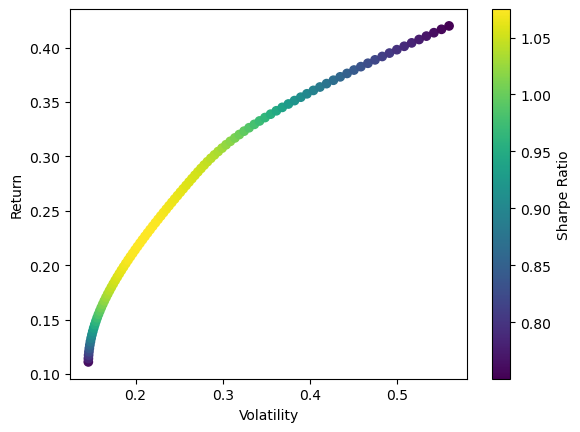

In [214]:
w = w_min
num_ports = 100
r_min = ret(r,w_min)
gap = (max(r) - r_min) / num_ports

all_weights = np.zeros((num_ports, len(dfret.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)

x0= w_min

for i in range(num_ports):
    port_ret = r_min + i*gap 
    double_constraints = LinearConstraint([np.ones(dfret.shape[1]), r], [1,port_ret], [1,port_ret])
    # equality constraint : sum of weight == 1
    # equality constraint : portfolio return == port_ret
    portfvola = lambda w: np.sqrt(np.dot(w,np.dot(w,covar))*252)
    res = minimize(portfvola, x0, method='trust-constr', constraints=double_constraints, bounds=bounds)
    all_weights[i,:] = res.x # populate the weights for diff i
    ret_arr[i] = port_ret
    vol_arr[i] = vol(res.x, covar)
    
sharpe_arr = ret_arr/ vol_arr

plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

In [251]:
df_sharpe = pd.DataFrame({'sharpe':sharpe_arr, 
                          'ret_arr':ret_arr, 'vol_arr':vol_arr})

In [252]:
all_weights_df = pd.DataFrame(all_weights)
all_weights_df.columns = tickers

In [253]:
df_sharpe = df_sharpe.join(all_weights_df, how='left')

In [269]:
df_sharpe = df_sharpe.sort_values('sharpe',ascending=False)

In [270]:
print(tickers)

for i in range(10):
    # 0 - 9
    # 10 - 19
    # 90-99
    ave_sharpe = df_sharpe['sharpe'][i*10:i*10+10].mean()
    print()
    print('average sharpe = ', round(ave_sharpe,2))
    
    ave_weights = []
    for each in tickers:
        ave_weight = df_sharpe[each][i*10:i*10+10].mean()
        ave_weights.append(round(ave_weight,3))
        
    print('ave_weights')
    print(ave_weights)

['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'BRK-A', 'V', 'JNJ', 'WMT']

average sharpe =  1.07
ave_weights
[0.092, 0.393, 0.016, 0.0, 0.001, 0.138, 0.119, 0.037, 0.118, 0.086]

average sharpe =  1.07
ave_weights
[0.096, 0.416, 0.014, 0.0, 0.001, 0.146, 0.109, 0.039, 0.104, 0.075]

average sharpe =  1.06
ave_weights
[0.106, 0.473, 0.01, 0.0, 0.001, 0.165, 0.083, 0.043, 0.07, 0.05]

average sharpe =  1.05
ave_weights
[0.092, 0.475, 0.011, 0.0, 0.002, 0.174, 0.076, 0.021, 0.086, 0.064]

average sharpe =  1.02
ave_weights
[0.034, 0.471, 0.012, 0.0, 0.002, 0.219, 0.083, 0.009, 0.097, 0.072]

average sharpe =  0.99
ave_weights
[0.019, 0.4, 0.013, 0.0, 0.003, 0.279, 0.091, 0.008, 0.108, 0.08]

average sharpe =  0.94
ave_weights
[0.015, 0.314, 0.014, 0.0, 0.003, 0.34, 0.099, 0.006, 0.119, 0.089]

average sharpe =  0.88
ave_weights
[0.012, 0.229, 0.015, 0.0, 0.004, 0.402, 0.107, 0.005, 0.129, 0.097]

average sharpe =  0.83
ave_weights
[0.006, 0.161, 0.012, 0.002, 0.003, 0.546, 0.085, 0.0

In [271]:
weights = [0.092, 0.393, 0.016, 0.0, 0.001, 0.138, 0.119, 0.037, 0.118, 0.086]

In [275]:
pd.DataFrame({'Tickers':tickers, 'Weights':weights}).sort_values('Weights', ascending=False)

,Tickers,Weights
1,MSFT,0.393
5,TSLA,0.138
6,BRK-A,0.119
8,JNJ,0.118
0,AAPL,0.092
9,WMT,0.086
7,V,0.037
2,AMZN,0.016
4,META,0.001
3,GOOGL,0.000


<font color='red'> Highest sharpe ratio of 1.07 is attained with high weight in MSFT (40%).  The performance of MSFT dominates the portfolio. TSLA, JNJ and WMT have weights of 12%, the rest are less than 10%. 

# Thank you for reading :)